<a href="https://colab.research.google.com/github/hmblackwood/The-Good-Dog-Project/blob/main/The_Good_Dog_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

#🐕 The Good Dog Project 🦮

##Summary: I created a multi-class image classifier model with Tensorflow 2.0 to identify the breed of dog based on an image.

##1. Problem
Identify the breed of a dog based on an image.


##2. Data
The data is from the Stanford Dogs Dataset from the Dog Breed Indentification Completition on Kaggle.
https://www.kaggle.com/c/dog-breed-identification/data
Citation:
@misc{dog-breed-identification,
    author = {Will Cukierski},
    title = {Dog Breed Identification},
    year = {2017},
    howpublished = {\url{https://kaggle.com/competitions/dog-breed-identification}},
    note = {Kaggle}
}


##3. Evaluation
Model is evaluated on Multi Class Log Loss between the predicted probability and the obeserved target.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation


##4. Features
Information about the data:
- Unstructured data (images).
- 120 different classes, one for each breed of dog, into which images will be sorted.
- 10,000+ images of dogs in the training set, all of them labeled.
- 10,000+ images of dogs in the test set, all unlabeled. The model will be making predictions based on these.


In [2]:
# Import Tensorflow and Tensorflow Hub

import tensorflow as tf
print("TF version:", tf.__version__)
import tensorflow_hub as hub
print("TF Hub Version:", hub.__version__)

TF version: 2.17.1
TF Hub Version: 0.16.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


# Initial Data Exploration

In [5]:
# View labels of my data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Good Dog Project/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


✅ Exploration of the label file looks good, with 120 unique breeds and 10,222 labeled examples on which to train my model.

In [7]:
# How many images of each of the 120 breeds?
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


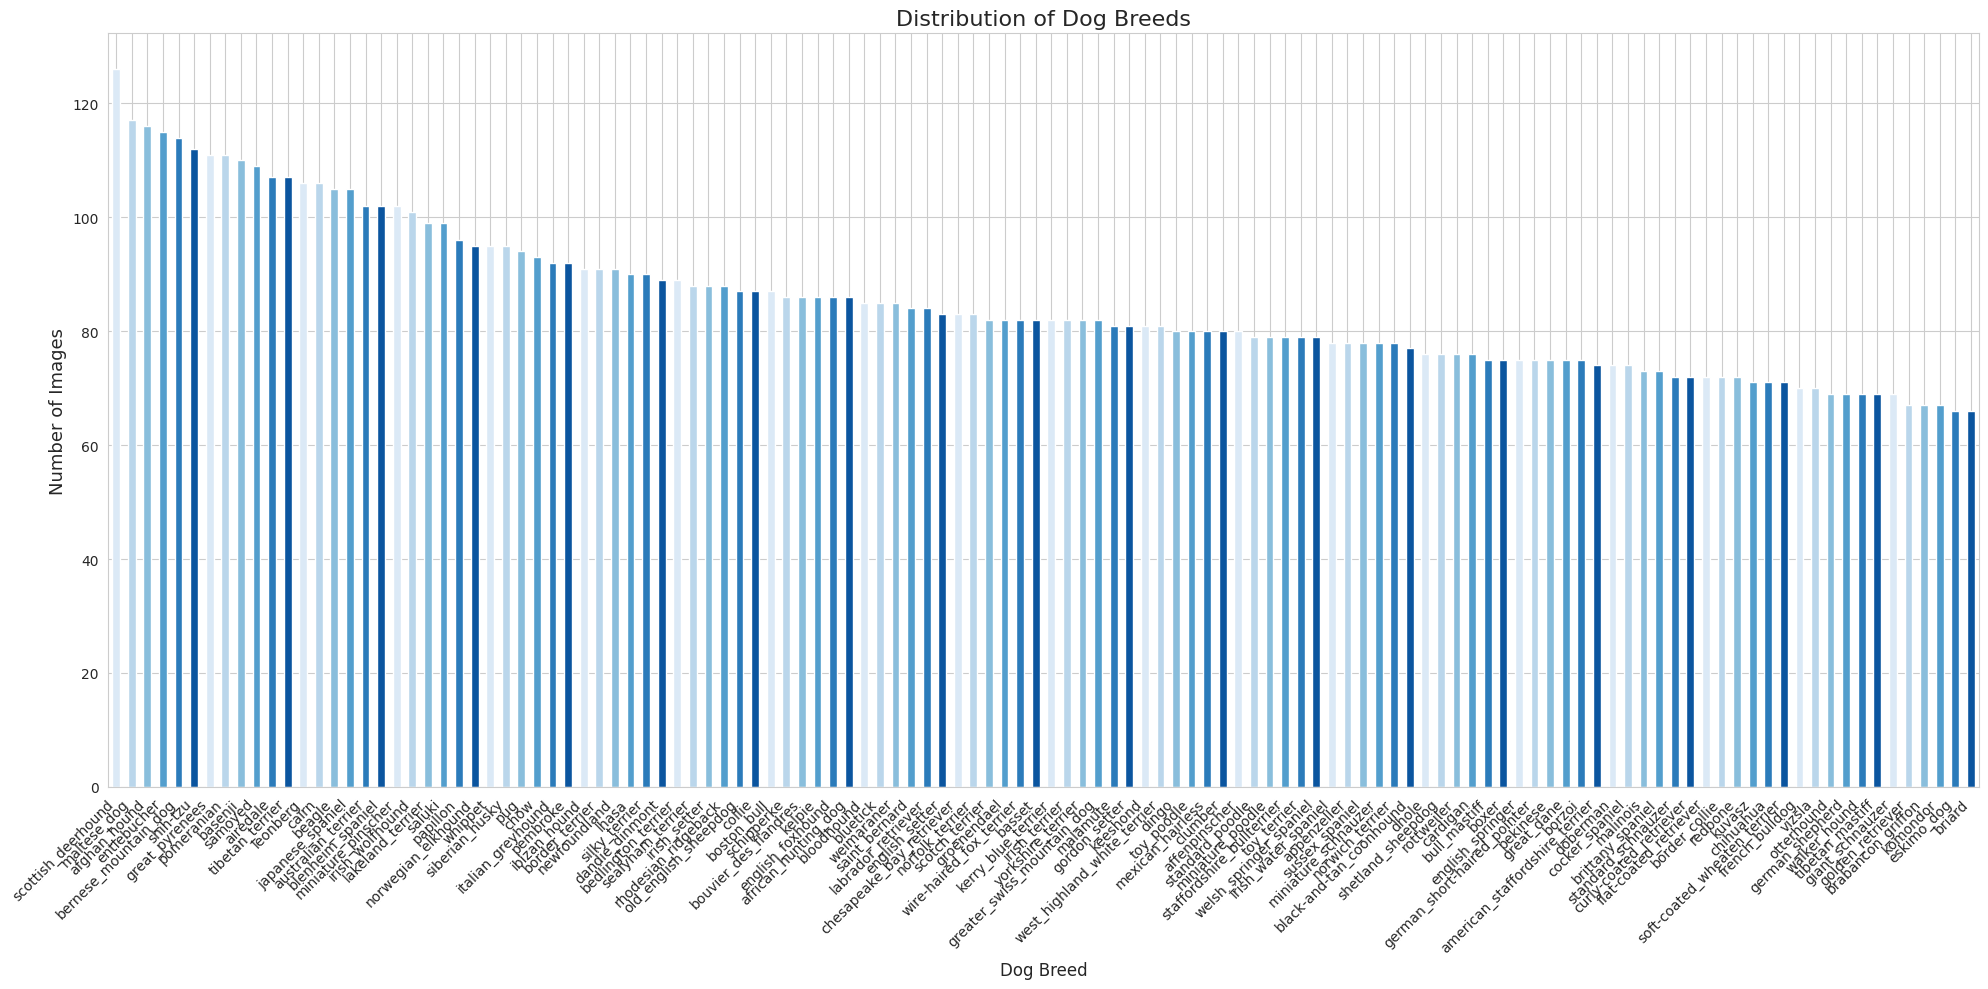

In [8]:
# I created a graph to display how many images of each breed I have.

breed_counts = labels_csv["breed"].value_counts()

# Set style and color pallette using Seaborn
sns.set_style("whitegrid")
sns.set_palette("Blues")

# Create bar chart
plt.figure(figsize=(20, 10))
breed_counts.plot(kind="bar", color=sns.color_palette())

# Label the chart for easier readability
plt.title("Distribution of Dog Breeds", fontsize=16)
plt.xlabel("Dog Breed", fontsize=12)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout() # Fix layout so X axis labels don't overlap.

plt.show;

In [9]:
# Calculate the median number of images per class
labels_csv["breed"].value_counts().median()

82.0

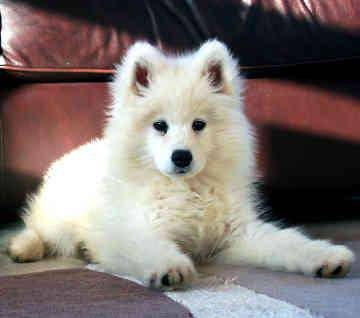

In [10]:
# View an image from the test set
from IPython.display import Image
Image("/content/drive/MyDrive/Good Dog Project/test/002c58d413a521ae8d1a5daeb35fc803.jpg")

## Now, that's a good dog! 😃

# Preparing Images and Their Labels

In [11]:
# Check the image file names
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# Create pathnames from the image IDs
filenames = [f"drive/MyDrive/Good Dog Project/train/{fname}.jpg" for fname in labels_csv["id"]]

In [13]:
# Check the first 10. These are currently strings, not the actual images.
filenames [:10]

['drive/MyDrive/Good Dog Project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Good Dog Project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Good Dog Project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Good Dog Project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Good Dog Project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Good Dog Project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Good Dog Project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Good Dog Project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Good Dog Project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Good Dog Project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [14]:
# Verify that the number of filenames matches the number of image files

import os
if len(os.listdir("drive/MyDrive/Good Dog Project/train/")) == len(filenames):
  print("Filenames match number of files.")
else:
  print("Filenames do not match number of files. Check the target directory.")

Filenames match number of files.


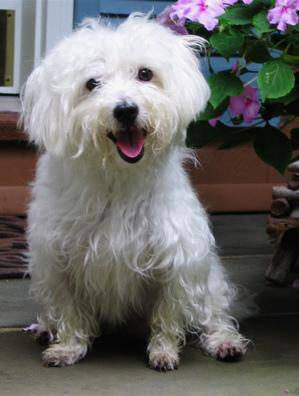

In [15]:
# Verify that data is in the correct format. Picked a random number for 4242.

Image(filenames[4242])

In [16]:
labels_csv["breed"][4242]

'maltese_dog'

## Another good dog! 😃

## Prepare the Labels

In [17]:
# Make a numpy array of the labels
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
# Verify the length and that it matches with number of labels before. It does.
len(labels)

10222

In [19]:
# Verify that the number of labels equals the number of filenames.
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames. Check the data directories.")

Number of labels matches number of filenames.


In [25]:
# The labels are strings now. Need to convert them into numbers.
# Find out how many unique label values there are.
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

## Turn strings into boolean arrays
- Befoe I can convert the values into tensors, I need to make them into numbers. I'll follow these steps:
1. Convert the strings into boolean arrays
2. Convert the boolean arrays into tensors

In [26]:
# Turn a single label into a boolean array
# I'll use a comparison operator to compare the first label to unique_breeds. It should give an array of true and false values. All values should be false, except one, which will be true.
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [27]:
# Turn all labels into boolean arrays
# I'll visualize the data and check that each array is all false values except for one true value, where the label matches.
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Turn boolean array into integers, which can be made into Tensors.
